# A Gentle Introduction to Transfer Learning

In [12]:
import sys
import os
import numpy as np
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler, SGD
from torch.autograd import Variable
from torchvision import models
from utils import get_gpu_name, get_number_processors, plot_pytorch_data_stream, train_model, create_dataset

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("PyTorch: ", torch.__version__)
print("Numpy: ", np.__version__)
print("Number of CPU processors: ", get_number_processors())
print("GPU: ", get_gpu_name())

%matplotlib inline
%load_ext autoreload
%autoreload 2

OS:  linux
Python:  3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
PyTorch:  0.2.0_3
Numpy:  1.13.3
Number of CPU processors:  24
GPU:  ['Tesla M60', 'Tesla M60', 'Tesla M60', 'Tesla M60']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
torch.backends.cudnn.benchmark=True # enables cudnn's auto-tuner

In [3]:
BATCH_SIZE = 64
SETS = ['train', 'val']

## Model and utilities

In [13]:
def finetune(dataloaders):
    num_class = len(dataloaders['train'].dataset.class_to_idx)
    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_class)
    model_ft = model_ft.cuda()
    #loss
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer = SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    model_ft = train_model(dataloaders, model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=25)
    return model_ft

In [5]:
def freeze_and_train(dataloaders):
    num_class = len(dataloaders['train'].dataset.class_to_idx)
    model_conv = models.resnet18(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False

    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, num_class)
    model_conv = model_conv.cuda()
    #loss
    criterion = nn.CrossEntropyLoss()

    # Observe that only parameters of final layer are being optimized as
    # oposed to before.
    optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
    model_conv = train_model(dataloaders, model_conv, criterion, optimizer, exp_lr_scheduler, num_epochs=25)
    return model_conv

## Datasets
We are going to use the dataset [hymenoptera](https://download.pytorch.org/tutorial/hymenoptera_data.zip)

In [6]:
DATA_ROOT = 'data'
HYMENOPTERA_ROOT = os.path.join(DATA_ROOT, 'hymenoptera_data')

In [7]:
data_hymenoptera = create_dataset(HYMENOPTERA_ROOT)

There are 2 clases in the dataset: {'bees': 1, 'ants': 0}
Sets sizes:  {'train': 244, 'val': 153}
Number of items in set train: {0: 123, 1: 121}
Number of items in set val: {0: 70, 1: 83}


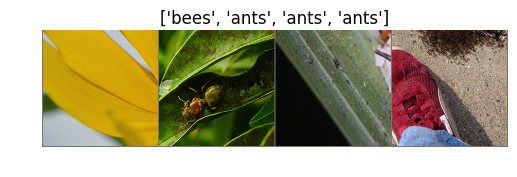

In [8]:
plot_pytorch_data_stream(data_hymenoptera['train'], max_images=4)

In [14]:
model = finetune(data_hymenoptera)

Epoch 0/24
----------
train Loss: 0.0215 Acc: 0.6270
val Loss: 0.0159 Acc: 0.8170

Epoch 1/24
----------
train Loss: 0.0149 Acc: 0.8197
val Loss: 0.0105 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.0106 Acc: 0.8689
val Loss: 0.0079 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.0087 Acc: 0.9057
val Loss: 0.0068 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.0066 Acc: 0.9467
val Loss: 0.0064 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.0056 Acc: 0.9344
val Loss: 0.0063 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.0060 Acc: 0.9180
val Loss: 0.0060 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.0040 Acc: 0.9713
val Loss: 0.0066 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.0056 Acc: 0.9303
val Loss: 0.0065 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.0069 Acc: 0.9262
val Loss: 0.0063 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.0054 Acc: 0.9344
val Loss: 0.0062 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.0055 Acc: 0.9303
val Loss: 0.0062 Acc: 0.9477

Ep